# Анализ тональности текста

В этом семинаре мы познакомимся с задачей [анализа тональности текста](https://ru.wikipedia.org/wiki/Анализ_тональности_текста) (sentiment analysis). В кратце, нужно по отзыву/тексту определить его тональность: положительную или отрицательную окраску. Иными словами это задача классификации. Но для начала нужно подшготовить данные, получить некоторые численные представления слов, а дальше уже решать саму задачу.

## Чтение данных

Скачаем и распакуем [датасет](http://ai.stanford.edu/~amaas/data/sentiment/). 

In [1]:
# !wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
# !tar -xvzf aclImdb_v1.tar.gz

Теперь напишем функцию для чтения данных.

In [2]:
import os

def read_raw_reviews(path):
    raw_reviews, raw_ratings = [], []

    for sentiment in ['neg', 'pos']:
        for fname in os.listdir(os.path.join(path, sentiment)):
            _, rating = fname.strip().split('_')
            with open(os.path.join(path, os.path.join(sentiment, fname)), 'r', encoding='utf-8') as file:
                raw_reviews.append(file.readlines()[0])
            raw_ratings.append(int(rating[:-4]) > 5)
        
    return raw_reviews, raw_ratings

In [3]:
path_to_train = './aclImdb/train/'
path_to_test = './aclImdb/test/'

raw_reviews_train, raw_ratings_train = read_raw_reviews(path_to_train)
raw_reviews_test, raw_ratings_test = read_raw_reviews(path_to_test)

In [4]:
len(raw_reviews_train), len(raw_reviews_test)

(25000, 25000)

Посмотрим на данные.

In [5]:
raw_reviews_train[0], raw_ratings_train[0]

('A truly, truly dire Canadian-German co-production, the ever-wonderful Rosanna Arquette plays an actress whose teenage daughter redefines the term "problem child" - a few uears prior to the "action" the child murdered her father, and mum took the fall for the offspring. Now she\'s moved up to the Northwest US to start over, but her child still has a problem in that she\'s devoted to her mother. So devoted in fact that she kills anyone who might be seen as a threat to their bond.<br /><br />Unfortunately Mandy Schaeffer (as the daughter) murders more than people - she delivers such a terrible performance that she also wipes out the movie, though the incoherent script, useless direction and appalling music (check out the saxophone the first time she displays her bikini-clad bod) don\'t help any; we\'re supposed to find her sexy and scary, but she fails on both counts. Almost completely unalluring and not even bad enough to be amusing (not to mention the fact that Arquette and Schaeffer 

## Векторные представления слов

Теперь загрузим библиотеку [`gensim`](https://github.com/RaRe-Technologies/gensim) для [тематического моделирования](https://ru.wikipedia.org/wiki/Тематическое_моделирование). В частности она имеет предобученные [векторные представления слов](https://en.wikipedia.org/wiki/Word_embedding) (word embedding), а также умеет их тренировать для любых корпусов.

In [6]:
import gensim
import gensim.downloader

paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress


Для вывода предобученных векторов, можно воспользоваться `gensim.downloader.info()`.

In [7]:
list(gensim.downloader.info()['models'].keys())

['fasttext-wiki-news-subwords-300',
 'conceptnet-numberbatch-17-06-300',
 'word2vec-ruscorpora-300',
 'word2vec-google-news-300',
 'glove-wiki-gigaword-50',
 'glove-wiki-gigaword-100',
 'glove-wiki-gigaword-200',
 'glove-wiki-gigaword-300',
 'glove-twitter-25',
 'glove-twitter-50',
 'glove-twitter-100',
 'glove-twitter-200',
 '__testing_word2vec-matrix-synopsis']

Выбирем `glove-twitter-100` (можно любой другой, но желательно чтобы оба домена были близкими).

In [8]:
model_name = 'glove-twitter-100'
model = gensim.downloader.load(model_name)
print('Word vocabulary size: {}'.format(len(model.vocab)))

Word vocabulary size: 1193514


Можно посмотреть на сами вектора слов.

In [9]:
# now you can get word vectors !
model.get_vector('anything')

array([-4.0345e-01,  2.7251e-01,  2.1853e-01,  3.2440e-01, -3.9078e-01,
        3.1568e-01,  6.7064e-01, -2.3172e-01,  2.7944e-01,  8.5353e-01,
        3.1557e-01, -7.1326e-01, -5.1827e+00, -1.5941e-01, -3.6804e-01,
        8.8010e-02, -4.8119e-01, -1.5729e-01,  2.3228e-02,  5.1899e-01,
        3.8920e-01,  1.6812e-01, -4.8545e-01,  3.0454e-01,  3.9643e-01,
        8.5730e-01,  3.2853e-01,  8.2905e-02,  8.4235e-02, -3.6721e-01,
        1.5191e-01,  4.5757e-01, -5.3428e-01,  3.5136e-01, -6.5984e-01,
        4.5150e-02,  3.7618e-01, -4.9815e-01, -2.4063e-01,  5.0031e-02,
       -4.3774e-01, -7.3420e-03,  7.1933e-02, -2.3923e-01,  5.2413e-01,
       -1.2460e-01,  1.3120e-01,  2.7869e-01, -5.6155e-01,  2.7182e-01,
       -2.4129e-01,  4.0371e-01, -8.9041e-02, -9.9831e-02,  4.4765e-01,
        5.2124e-01,  2.0899e-01, -4.1132e-02, -7.1021e-02,  3.6736e-01,
        2.3234e-01,  1.6121e-01,  2.1826e-01, -3.1339e-03,  2.9962e-01,
       -3.2263e-01, -2.8183e-01,  2.0653e-01, -4.0681e-01, -3.50

А можно посмотреть на самые "похожие" по мнению ворд2век.

In [10]:
# or query similar words directly. Go play with it!
model.most_similar('bread')

[('cheese', 0.8441256284713745),
 ('butter', 0.8039426803588867),
 ('toast', 0.7904373407363892),
 ('slice', 0.7709747552871704),
 ('chicken', 0.755040168762207),
 ('salad', 0.7542903423309326),
 ('cake', 0.7518615126609802),
 ('meat', 0.7513599395751953),
 ('soup', 0.747043251991272),
 ('dough', 0.7461358308792114)]

In [11]:
model.most_similar(positive=["coder", "money"], negative=["brain"])

[('broker', 0.5820155739784241),
 ('bonuses', 0.5424473285675049),
 ('banker', 0.538511335849762),
 ('designer', 0.5197198390960693),
 ('merchandising', 0.4964233934879303),
 ('treet', 0.49220192432403564),
 ('shopper', 0.4920561909675598),
 ('part-time', 0.49128279089927673),
 ('freelance', 0.4843311905860901),
 ('aupair', 0.4796452522277832)]

Извлечём матрицу представлений слов.

In [12]:
import numpy as np

In [13]:
# extract embeddings from model
# use zero vector for pading and random vector for unknown token
# pading index must be at index 0
# unknown token must be at index 1
embeddings_weights = padavan.get.vectors.grom.model # TODO

assert np.allclose(embeddings_weights[0].sum(), 0), 'Padding token is not zero vector'
print('Embedding matrix shape: {}'.format(embeddings_weights.shape))

Embedding matrix shape: (1193516, 100)


## Визуализация векторов

Поскольку нормальные люди не умееют видеть пространство размерности больше чем 3, то нужно каким-нибудь способом понизить размерность до трёх, а лучше двух. Существует множество способов сделать это.
Самые популярные это [метод главных компонент](https://ru.wikipedia.org/wiki/Метод_главных_компонент) (principal component analysis, `PCA`) и [стохастическое вложение соседей с t-распределением](https://ru.wikipedia.org/wiki/Стохастическое_вложение_соседей_с_t-распределением) (t-distributed stochastic neighbor embedding, `t-SNE`, `TSNE`).

В силу того, что `PCA` это линейное преобразование, а `TSNE` пытается [сохранить расстояния](https://habr.com/post/267041/) после преобразования (которое не обязаетльно линейно), то будем использовать последний.

In [14]:
# Let's use that to plot 1000 most frequent words
words = sorted(model.vocab.keys(), 
               key=lambda word: model.vocab[word].count,
               reverse=True)[:1000]

In [15]:
# for each word, compute it's vector with model
word_vectors = student.gemme.vectors # TODO

In [16]:
assert isinstance(word_vectors, np.ndarray)
assert word_vectors.shape == (len(words), model.vectors.shape[-1])
assert np.isfinite(word_vectors).all()

In [17]:
from sklearn.manifold import TSNE

In [18]:
# map word vectors onto 2d plane with PCA. Use good old sklearn api (fit, transform)
# after that, normalize vectors to make sure they have zero mean and unit variance
vectors_tsne = tisne.me # TODO

In [19]:
assert vectors_tsne.shape == (len(word_vectors), 2), "there must be a 2d vector for each word"
assert max(abs(vectors_tsne.mean(0))) < 1e-5, "points must be zero-centered"
assert max(abs(1.0 - vectors_tsne.std(0))) < 1e-2, "points must have unit variance"

Волшебный код, который красиво рисует :)

In [20]:
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook
output_notebook()

def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=600, height=400, show=True, **kwargs):
    """ draws an interactive plot for data points with auxilirary info on hover """
    
    if isinstance(color, str):
        color = [color] * len(x)
        
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })
    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)
    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    
    if show:
        pl.show(fig)
        
    return fig

Loading BokehJS ...

Создадим отображение из слов и индексы.

In [21]:
# create mapping from word to index and vice versa
word2idx = # TODO
idx2word = # TODO

for i, word in enumerate(idx2word):
    assert word2idx[word] == i, 'direct and inverse mappings are not correct!'
assert len(model.vocab) == len(word2idx), 'there are no pad and unk tokesn'

In [22]:
draw_vectors(vectors_tsne[:, 0], vectors_tsne[:, 1], token=idx2word[::1000])

Figure(id='1003', ...)

# Классификация с помощью нейронной сети.

Теперь перейдём к задаче анализа тональности текста. Нам требуется определить является ли отзыв положительным или отрицательным. Иными словами мы решаем задачу классификации текста на 2 класса.

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [24]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

Для удобной работы с данными для обработки текстов есть библиотека [`torchtext`](https://torchtext.readthedocs.io/en/latest/), которая повзоляет более тонко настраивать батч генераторы, например, батч может содержать предложения почти одинаковой длины.

In [25]:
import torchtext

Для начала нужно создать поля, одно для текста, другое для метки класса.

In [26]:
import re

PUNCTUATION_PATTERN = re.compile(r'(\w*)(\W)(\w*)')

def tokenize(text):
    text = re.sub(r'<br /><br />', '', text)     # remove <br /><br />
    
    text = PUNCTUATION_PATTERN.sub(r'\1 \2 \3', text)
    
    return text.split()

In [27]:
text_field = torchtext.data.Field(lower=True,
                                  tokenize=tokenize,
                                  include_lengths=True,
                                  batch_first=False)

label_field = torchtext.data.Field(sequential=False,
                                   use_vocab=False,
                                   batch_first=False,
                                   is_target=True)

**Внимание**. В тензорах первая размерность отвечает за длину последовательности, а потом уже идёт размер батча (`batch_first=False`).

Теперь обернём сэмплы в класс примеров (`data.Example`).

In [28]:
import tqdm

In [29]:
example_data_train = [torchtext.data.Example.fromdict(data={'question_text': text,
                                                            'target'       : target},
                                                      fields={'question_text': ('text',   text_field),
                                                              'target'       : ('target', label_field)})
                      for text, target in tqdm.tqdm(zip(raw_reviews_train, raw_ratings_train),
                                                    total=len(raw_reviews_train))]

example_data_test = [torchtext.data.Example.fromdict(data={'question_text': text,
                                                           'target'       : target},
                                                     fields={'question_text': ('text',   text_field),
                                                             'target'       : ('target', label_field)})
                     for text, target in tqdm.tqdm(zip(raw_reviews_test, raw_ratings_test),
                                                   total=len(raw_reviews_test))]

100%|██████████| 25000/25000 [00:11<00:00, 2088.83it/s]


Sanity check

In [30]:
' '.join(example_data_train[0].text), example_data_train[0].target

('a truly , truly dire canadian - german co - production , the ever - wonderful rosanna arquette plays an actress whose teenage daughter redefines the term " problem child " - a few uears prior to the " action " the child murdered her father , and mum took the fall for the offspring . now she \' s moved up to the northwest us to start over , but her child still has a problem in that she \' s devoted to her mother . so devoted in fact that she kills anyone who might be seen as a threat to their bond . unfortunately mandy schaeffer ( as the daughter ) murders more than people - she delivers such a terrible performance that she also wipes out the movie , though the incoherent script , useless direction and appalling music ( check out the saxophone the first time she displays her bikini - clad bod ) don \' t help any ; we \' re supposed to find her sexy and scary , but she fails on both counts . almost completely unalluring and not even bad enough to be amusing ( not to mention the fact th

Создадим датасеты.

In [31]:
import random

In [32]:
RANDOM_SEED = 314159

random.seed(RANDOM_SEED)

In [33]:
train = torchtext.data.Dataset(example_data_train,
                               fields=[('text'  , text_field),
                                       ('target', label_field)])

test = torchtext.data.Dataset(example_data_test,
                              fields=[('text'  , text_field),
                                      ('target', label_field)])

train, dev = train.split(split_ratio=0.8,
                         stratified=True,
                         strata_field='target',
                         random_state=random.getstate())

In [34]:
print('train size:\t{:>5}'.format(len(train)))
print('dev size  :\t{:>5}'.format(len(dev)))
print('test size :\t{:>5}'.format(len(test)))

train size:	20000
dev size  :	 5000
test size :	25000


Нам нужно создать словари. Можно использовать нашу матрицу представлений или загрузить предобученную. Будем пользоваться нашей, хотя она совпадает с `glove.twitter.27B.100d` из `torchtext`.

In [35]:
def unk_init(tensor):
    return torch.rand_like(tensor)

In [36]:
use_our = True  # False if you need some other
if use_our:
    model.save_word2vec_format(model_name)

    vectors = torchtext.vocab.Vectors(name=model_name, cache='./', unk_init=unk_init)
    
    text_field.build_vocab(train, vectors=vectors)
else:
    text_field.build_vocab(train, vectors='glove.twitter.27B.100d', unk_init=unk_init)

In [37]:
vocab = dict(text_field.vocab.stoi)
print('Word vocabulary size {}'.format(len(vocab)))

Word vocabulary size 69673


In [38]:
# проверим всё ли правильно
# works only in python >= 3.6
import sys

if '3.6.3' in sys.version:
    for word in vocab:
        if word in word2idx:
            assert (text_field.vocab.vectors[vocab[word]].cpu().numpy() == embeddings_weights[word2idx[word] + 2]).all()

Наконец, создадим батч итераторы.

In [39]:
batch_size = 64

train_iter = torchtext.data.BucketIterator(train,
                                           batch_size,
                                           sort_key=lambda x: len(x.text),
                                           repeat=False,
                                           shuffle=True,
                                           sort=False,
                                           train=True,
                                           device=device)

dev_iter = torchtext.data.BucketIterator(dev,
                                         batch_size,
                                         sort_key=lambda x: len(x.text),
                                         repeat=False,
                                         sort=False,
                                         train=False,
                                         device=device)

test_iter = torchtext.data.BucketIterator(test,
                                          batch_size,
                                          sort_key=None,
                                          repeat=False,
                                          shuffle=False,
                                          sort=False,
                                          train=False,
                                          device=device)

Возьмём один батч и проверим всё ли верно.

In [40]:
for batch in dev_iter:
    break

for word_ind in batch.text[0][:, 0]:
    if word_ind == text_field.vocab.stoi['<pad>']:
        break
    print(text_field.vocab.itos[word_ind], end=' ')

i ' ve seen better production quality on youtube ! i pity the actors , as the writing was terrible and the direction shocking , not sure how they could get the lines out - i really doubt any actor would have been able to salvage this movie no matter how good they were . the characters were not developed at all , and there was no real cohesion in the plot which just seemed to go nowhere much . it ' s a shame really , as the premise for the movie was good and with better production quality , direction and script it could have been a decent movie . it certainly was not a comedy , unless you laugh out loud at the dubbing - which was amateurish , even the english actors sounded weird . 

In [41]:
' '.join(next(iter(dev)).text)

"i ' ve seen better production quality on youtube ! i pity the actors , as the writing was terrible and the direction shocking , not sure how they could get the lines out - i really doubt any actor would have been able to salvage this movie no matter how good they were . the characters were not developed at all , and there was no real cohesion in the plot which just seemed to go nowhere much . it ' s a shame really , as the premise for the movie was good and with better production quality , direction and script it could have been a decent movie . it certainly was not a comedy , unless you laugh out loud at the dubbing - which was amateurish , even the english actors sounded weird ."

Теперь у нас есть батч итераторы. Перейдём к модели.

In [42]:
class TextClassificationModel(nn.Module):
    def __init__(self,
                 vocab,
                 hidden_size=64,
                 freeze=True):
        super(__class__, self).__init__()
        
        self.vocab = vocab
        
        # TODO: create embedding layer, freeze embedding if needed
        self.embedder = ...
        
        # TODO: create LSTM
        _, emb_size = self.vocab.vectors.shape
        self.rnn = ... 
        
        # TODO: create classifier
        self.classifier = ...
    
    def forward(self, inputs):
        # inputs = words, seq_lens
        
        words, seq_lens = inputs.text[0], inputs.text[1]
        # words:    [time, batch]
        # seq_lens: [batch]
        
        mask = torch.ne(words, self.vocab.stoi['<pad>'])
        
        # TODO: get embeddings of words
        emb = ...
        
        # TODO: eat them by RNN
        rnn_output = ...
        
        # TODO: calculate logits
        logits = ...

        return logits

Инициализируем сеть.

In [43]:
net = TextClassificationModel(text_field.vocab).to(device)
net

TextClassificationModel(
  (embedder): Embedding(69673, 100)
  (rnn): LSTM(100, 64, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [44]:
# easy augmentation
def word_dropout(inp, keep_prob=0.8):
    # TODO
    return inp

Напишем стандартную для бинарной классификации функции потерь -- кросс-энтропию.

In [46]:
def calc_loss(inp, target):
    # TODO
    return 0

Проверим ничего ли не падает.

In [47]:
for batch in train_iter:
    break
    
batch

loss = calc_loss(net(batch), batch.target[:, None].float()).item()

assert 0.61 <= loss <= 0.79, f'Smth wrong with loss ({loss})'

## Обучение


Напишем несколько полезных функций для обучения модели.

In [48]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline

In [49]:
def calc_accuracy(probas, target, thresh=0.5):
    return ((probas > thresh) == target).mean()
    

def epoch_step(model,
               data_iter,
               opt=None,
               desc=None):
    loss_loc = n = 0.0
    probas, targets = [], []
    for batch in tqdm.tqdm(data_iter,
                           desc=desc,
                           leave=False,
                           mininterval=1):
        # use word dropout if available
        
        # TODO: calculate logits
        logits = ...
        
        # TODO: calculate loss
        loss = ...

        # TODO: do backward
        if opt is not None:
            ...

        loss_loc += loss.item()
        probas.extend(torch.sigmoid(logits).detach().cpu().numpy())
        targets.extend(batch.target.cpu().numpy())
        n += 1
    
    loss = loss_loc/n
    probas, targets = np.array(probas).flatten(), np.array(targets)
    
    metric = calc_accuracy(probas, targets)
    
    return loss, metric


def plot_results(results):
    clear_output(True)
    
    plt.subplots(1, 2)

    plt.subplot(1, 2, 1)
    for form in results:
        plt.plot(results[form]['loss'],
                 label='{} {:.3}'.format(form, results[form]['loss'][-1]))
    plt.title('Loss')
    plt.xlabel('Epochs number')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(ls='--')

    plt.subplot(1, 2, 2)
    for form in results:
        plt.plot(results[form]['metric'],
                 label='{} {:.3}'.format(form, results[form]['metric'][-1]))
    plt.title('Accuracy')
    plt.xlabel('Epochs number')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(ls='--')

    plt.show()


def train_model(model,
                opt,
                train_iter,
                dev_iter,
                scheduler=None,
                epochs=15,
                initial_epoch=0,
                results=None):
    if results is None:
        results = {'train': {'loss': [], 'metric': []},
                   'dev'  : {'loss': [], 'metric': []}}

    for epoch in range(initial_epoch + 1, epochs + 1):
        # use scheduler if available
        
        model.train()
        desc = '[ Training {}/{} ]'.format(epoch, epochs)
        loss_loc, acc_loc = epoch_step(model, train_iter, opt, desc=desc)
        results['train']['loss'].append(loss_loc)
        results['train']['metric'].append(acc_loc)

        with torch.no_grad():
            model.eval()
            desc = '[ Validating {}/{} ]'.format(epoch, epochs)
            loss_loc, acc_loc = epoch_step(model, dev_iter, desc=desc)
            results['dev']['loss'].append(loss_loc)
            results['dev']['metric'].append(acc_loc)
            
            # save best if needed

        plot_results(results)
        
    return results

Здесь любимый оптимизатор.

In [50]:
opt = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()))

Наконец, обучим модель.

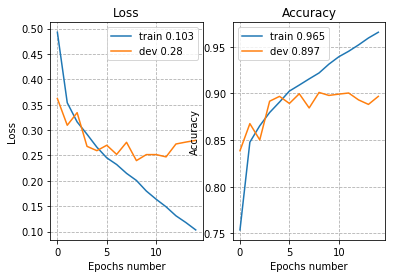

In [51]:
results = train_model(net, opt, train_iter, dev_iter)

Финальный результат.

In [52]:
with torch.no_grad():
    net.eval()
    loss_loc, acc_loc = epoch_step(net, test_iter, desc='[ Testing ]')
print('Test loss {:.3}\nTest accuracy {:.4}'.format(loss_loc, acc_loc))

Test loss 0.301
Test accuracy 0.8902


## Что ещё можно попробовать

#### Векторные представления

Можно обучить сеть
- с дообучением векторных представлений (`freeze=False`)
- попробовать другие эмбеддинги
- с нуля, т. е. без предобученных эмбеддингов и без замораживания (`freeze=False`)
- то же самое что предыдущий пункт, но с замораживанием (`freeze=True`)

Последний пункт может показаться странным, но задача очень простая и не обязательно иметь хорошие эмбеддинги :)

#### Предобработка

Написать продвинутую предобработку текстов, например, использовать лематизацию, стемминг. Использовать стоп слова. Удалять наиболее/наименее частотные слова.

#### Архитектура сети

Мы использовали очень простую сеть. Можно добавить свёрточные слои, селф-аттеншены, ручные признаки и т. д. и т. п. (но при этом не забываем про регуляризацию).

#### Аугментация данных

- Самый простой способ аугментировать данные, это заменять случайные слова на неизвестные (`<unk>`)
- Заменять слова на синонимы или на ближайшие соседние слова в смысле евклидовой метрики на векторных представлениях
- Можно делать двойной перевод, т. е. перевести на какой-нибудь другой язык и обратно